# Imports and Helpers

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from einops import rearrange
import random
from matplotlib.colors import rgb2hex
from tqdm.notebook import tqdm
import os
import copy
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2
import visualise_helper
import data_helper
print(sys.version)
import pandas as pd

%matplotlib inline
# %matplotlib ipympl

3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]


In [29]:
import seaborn as sns
import pandas as pd
sns.set_theme()
tqdm.pandas()
sns.set_style("dark")
import time
import timeout_decorator

## Load some houses

In [3]:
# Explore directory
DATA_DIR = "house_data/houses"
HOUSES_DIRS = [o for o in os.listdir(DATA_DIR) if os.path.isfile(os.path.join(DATA_DIR,o,"schematic.npy"))]
print("Num suable houses in dir:", len(HOUSES_DIRS))

Num suable houses in dir: 2532


In [8]:
# an array for some sample examples
selected_houses_dirs = ["workdir.2018-06-22-16:39:03.ip-172-31-9-250", # match box
    "workdir.2018-06-23-07:16:40.ip-172-31-5-36", # a house with deck
    "workdir.2018-06-22-20:45:54.ip-172-31-2-250", # quartz house
    "workdir.2018-06-23-08:09:44.ip-172-31-10-251", # tree house
    "workdir.2018-06-22-19:13:10.ip-172-31-13-79", # normal hut
    "workdir.2018-06-23-18:11:04.ip-172-31-0-19", # normal hut
]

houses_sample_size = 20
sample_houses_dirs = random.sample(HOUSES_DIRS, houses_sample_size)

sample_houses, selected_houses = pd.DataFrame(), pd.DataFrame()
for dir in sample_houses_dirs:
    sample_houses = sample_houses.append({
        'world': data_helper.pad_world(data_helper.trim_world_empty(data_helper.rearrange_sample(np.load(DATA_DIR + "/" + dir + "/schematic.npy")))),
        'dir': dir
    }, ignore_index=True)
    
for dir in selected_houses_dirs:
    selected_houses = selected_houses.append({
        'world': data_helper.pad_world(data_helper.trim_world_empty(data_helper.rearrange_sample(np.load(DATA_DIR + "/" + dir + "/schematic.npy")))),
        'dir': dir
    }, ignore_index=True)
    
print("selected", len(selected_houses_dirs), "houses") # the number of houses loaded
print("sampled", len(sample_houses), "houses") # the number of houses loaded

selected 6 houses
sampled 20 houses


In [9]:
print(selected_houses['dir'][0])
print(selected_houses['world'][0].shape)
print(sample_houses['dir'][0])
print(sample_houses['world'][0].shape)

workdir.2018-06-22-16:39:03.ip-172-31-9-250
(13, 13, 13, 2)
workdir.2018-08-23-17:10:38.ip-172-31-11-33
(17, 17, 17, 2)


# Visualiser

We use matplot lib visualization in which unique block IDs are assigned unique colour and unique variations of a block are marked by unique edge colour

colordict init success


  0%|          | 0/1 [00:00<?, ?it/s]

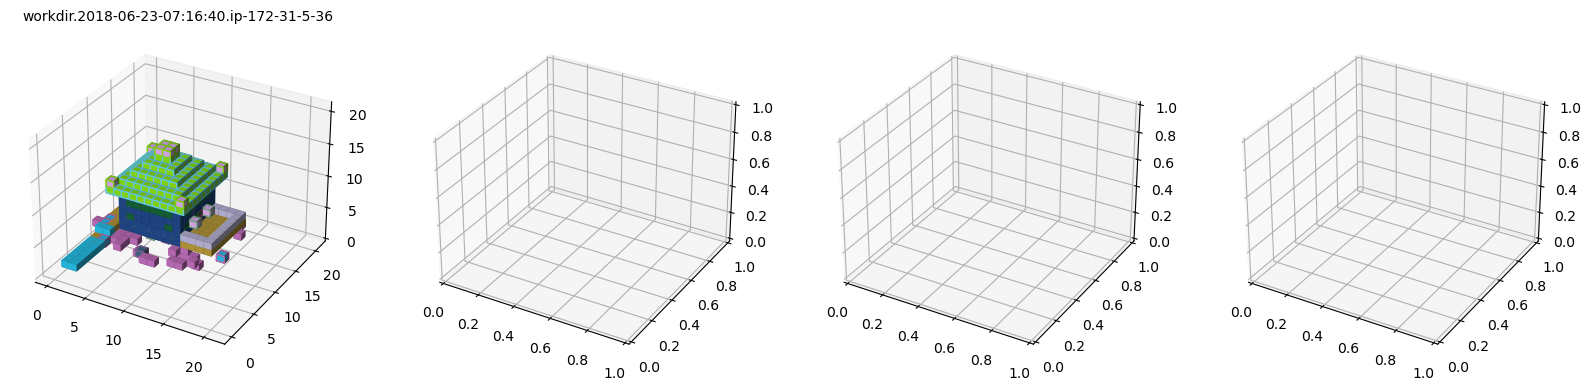

In [10]:
%matplotlib inline
plt.style.use(['default'])
visualise_helper.visualise_world(selected_houses[1:2])

colordict init success


  0%|          | 0/20 [00:00<?, ?it/s]

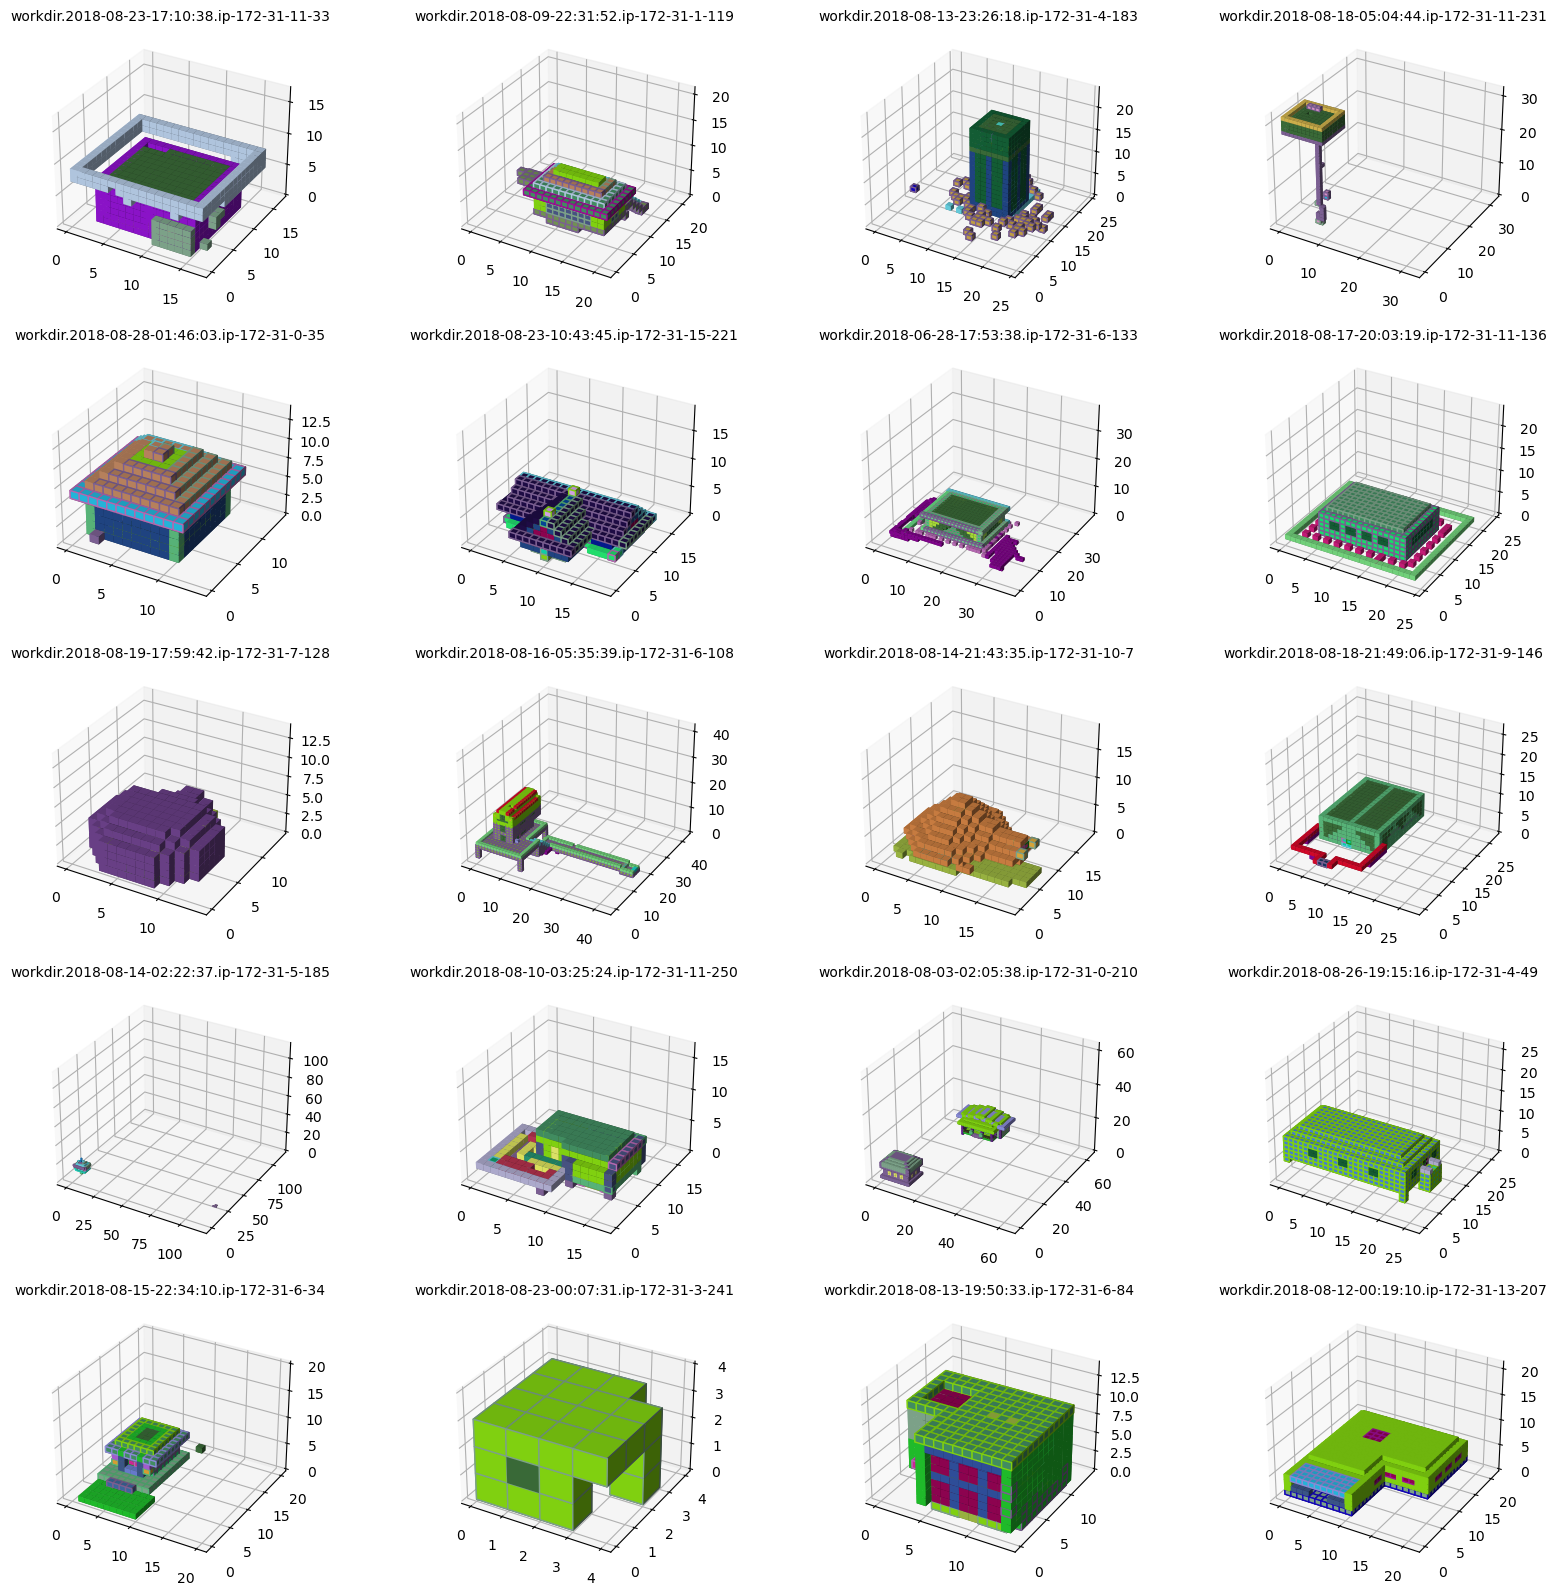

In [11]:
visualise_helper.visualise_world(sample_houses)

# Overview stats

- num unique block distribution (exclude meta)
- num unique block distribution (include meta)
- trimmed cube size distribution

While the original paper (cite) provides statistics on, e.g. block types and number of blocks in each house, it's not useful when it comes to selecting usable training examples for the model. 

We run python code to calculate the smallest cuboid box that the training example can fit in.

In [11]:
# load all houses

example_houses_df = pd.DataFrame()
for dir in tqdm(HOUSES_DIRS):
    try:
        example_houses_df = example_houses_df.append({
            'world': pad_world(trim_world_empty(rearrange_sample(np.load(DATA_DIR + "/" + dir + "/schematic.npy")))),
            'dir': dir
        }, ignore_index=True)
    except:
        print(dir)

print('loaded', len(example_houses_df), 'houses')

  0%|          | 0/2532 [00:00<?, ?it/s]

workdir.2018-08-19-00:14:55.ip-172-31-15-243
loaded 2531 houses


In [13]:
load_world_timeout = 10 # seconds

@timeout_decorator.timeout(load_world_timeout, timeout_exception=TimeoutError) 
def world_summary_data(world): 
    (x, _, _, _) = world.shape
    blockidarray = world[:,:,:,0]
    blockmetaarray = world[:,:,:,1]
    trimmedidarray = trim_world_empty(world)[:,:,:,0]
    
    # get size
    size = x

    # get unique block ids
    unique_ids = np.unique(blockidarray)
    nums_id_types = len(unique_ids)
    
    # get unique blocks variations
    block_list = rearrange(world, 'x y z m -> (x y z) m')
    nums_unique_types = len(np.unique(block_list, axis=0))
    
    # get air block percentage
    id_list = block_list[:,0]
    percentages_air = np.sum(np.equal(id_list, 0)) / len(id_list)
    
    # get air block percentage
    trimmed_id_list = rearrange(trimmedidarray, 'x y z -> (x y z)')
    trimmed_percentages_air = np.sum(np.equal(trimmed_id_list, 0)) / len(trimmed_id_list)
    
    return size, nums_id_types, nums_unique_types, percentages_air, trimmed_percentages_air

In [14]:
# process all worlds
stats_df = pd.DataFrame()

timeout_dirs = []

for i, row in tqdm(example_houses_df.iterrows(), total=example_houses_df.shape[0]):
    timeout_start = time.time()
    
    world = row['world']
    
    try: 
        size, nums_id_types, nums_unique_types, percentages_air, trimmed_percentages_air = world_summary_data(world)
    except TimeoutError:
        print("timeout loading: '{}'".format(row['dir']))
        timeout_dirs += [(row['dir'])]
        continue
    
    # check world
    # if size > 128:
        # print("!!! so big of a world!")
        # print("at", i, "size", x)

    # add to df
    stats_df = stats_df.append({
        'Size': size,
        'Num unique IDs': nums_id_types,
        'Num unique blocks': nums_unique_types,
        'Percentage air untrimmed': percentages_air,
        'Percentage air trimmed': trimmed_percentages_air,
        'dir': row['dir']
    }, ignore_index=True)
    
print('calculated stats for', len(stats_df), 'houses')
print(len(timeout_dirs), 'houses timed out and ignored')

  0%|          | 0/2532 [00:00<?, ?it/s]

timeout loading: 'workdir.2018-08-25-01:51:28.ip-172-31-9-19'
timeout loading: 'workdir.2018-08-05-20:35:42.ip-172-31-10-105'
timeout loading: 'workdir.2018-08-14-02:57:12.ip-172-31-4-64'
timeout loading: 'workdir.2018-07-31-00:21:12.ip-172-31-10-166'
timeout loading: 'workdir.2018-08-21-07:00:18.ip-172-31-7-194'
timeout loading: 'workdir.2018-08-23-00:04:03.ip-172-31-11-156'
timeout loading: 'workdir.2018-08-18-04:17:27.ip-172-31-9-98'
timeout loading: 'workdir.2018-08-05-21:44:47.ip-172-31-5-95'
timeout loading: 'workdir.2018-08-22-21:52:38.ip-172-31-10-113'
timeout loading: 'workdir.2018-08-25-16:54:11.ip-172-31-7-170'
timeout loading: 'workdir.2018-06-22-23:01:46.ip-172-31-15-114'
timeout loading: 'workdir.2018-08-17-05:07:45.ip-172-31-4-201'
timeout loading: 'workdir.2018-08-14-01:39:16.ip-172-31-11-213'
timeout loading: 'workdir.2018-06-27-00:42:02.ip-172-31-7-98'
timeout loading: 'workdir.2018-08-15-02:16:13.ip-172-31-15-183'
calculated stats for 2517 houses
15 houses timed out 

In [15]:
# save
# stats_df.to_pickle("data_stats_without_timeout.pkl")

In [22]:
# load
stats_df = pd.read_pickle("data_stats_without_timeout.pkl")

In [23]:
stats_df

Size  Num unique IDs  Num unique blocks  Percentage air untrimmed  \
0     23.0             4.0                7.0                  0.955618   
1     42.0            13.0               30.0                  0.985180   
2     72.0            20.0               32.0                  0.997471   
3      7.0             9.0               16.0                  0.688047   
4     15.0            13.0               21.0                  0.789630   
...    ...             ...                ...                       ...   
2512  52.0            14.0               22.0                  0.998073   
2513  11.0             8.0               14.0                  0.758077   
2514  13.0             9.0               16.0                  0.786982   
2515  19.0            23.0               44.0                  0.791223   
2516  23.0            21.0               38.0                  0.944029   

      Percentage air trimmed                                           dir  
0                   0.720497  workdir.2018-08-27-02:34:57.ip-172-31-11-175  
1                   0.935924  workdir.2018-08-25-03:26:13.ip-172-31-13-169  
2                   0.976503    workdir.2018-08-24-21:43:51.ip-172-31-9-19  
3                   0.490476    workdir.2018-08-10-05:48:27.ip-172-31-3-43  
4                   0.561728  workdir.2018-08-26-18:49:04.ip-172-31-10-229  
...                      ...                                           ...  
2512                0.995055   workdir.2018-08-16-20:07:10.ip-172-31-12-75  
2513                0.619835   workdir.2018-08-20-23:12:21.ip-172-31-3-191  
2514                0.727273   workdir.2018-08-05-20:21:21.ip-172-31-2-228  
2515                0.720858   workdir.2018-08-18-18:05:58.ip-172-31-3-100  
2516                0.740275  workdir.2018-08-20-03:29:18.ip-172-31-11-149  

[2517 rows x 6 columns]

## Deal with timeout

In [87]:
# save timeout list
timeout_df = pd.DataFrame({'timeout dir': timeout_dirs})
timeout_df.to_pickle("timeout_dirs.pkl")

NameError: name 'timeout_dirs' is not defined

In [282]:
# load
timeout_df = pd.read_pickle("timeout_dirs.pkl")

In [284]:
list(timeout_df['timeout dir'])

['workdir.2018-08-25-01:51:28.ip-172-31-9-19',
 'workdir.2018-08-21-17:51:55.ip-172-31-9-147',
 'workdir.2018-08-05-20:35:42.ip-172-31-10-105',
 'workdir.2018-08-14-02:57:12.ip-172-31-4-64',
 'workdir.2018-08-19-02:41:28.ip-172-31-4-60',
 'workdir.2018-07-31-00:21:12.ip-172-31-10-166',
 'workdir.2018-08-02-01:48:55.ip-172-31-14-200',
 'workdir.2018-08-21-07:00:18.ip-172-31-7-194',
 'workdir.2018-08-23-00:04:03.ip-172-31-11-156',
 'workdir.2018-08-18-04:17:27.ip-172-31-9-98',
 'workdir.2018-08-05-21:44:47.ip-172-31-5-95',
 'workdir.2018-08-22-21:52:38.ip-172-31-10-113',
 'workdir.2018-08-25-16:54:11.ip-172-31-7-170',
 'workdir.2018-06-22-23:01:46.ip-172-31-15-114',
 'workdir.2018-08-17-05:07:45.ip-172-31-4-201',
 'workdir.2018-08-14-01:39:16.ip-172-31-11-213',
 'workdir.2018-06-27-00:42:02.ip-172-31-7-98',
 'workdir.2018-08-15-02:16:13.ip-172-31-15-183']

In [295]:
err_id = example_houses['dir'][example_houses['dir'] == 'workdir.2018-08-25-01:51:28.ip-172-31-9-19'].index.tolist()[0]
err_id

501

In [303]:
err_world = example_houses.loc[err_id]['world']
err_world.shape

(406, 406, 406, 2)

In [305]:
(x, _, _, _) = err_world.shape
blockidarray = err_world[:,:,:,0]
blockmetaarray = err_world[:,:,:,1]
trimmedidarray = trim_world_empty(err_world)[:,:,:,0]

# get size
size = x

# get unique block ids
unique_ids = np.unique(blockidarray)
nums_id_types = len(unique_ids)

# get unique blocks variations
block_list = rearrange(err_world, 'x y z m -> (x y z) m')
nums_unique_types = len(np.unique(block_list, axis=0))

# get air block percentage
id_list = block_list[:,0]
percentages_air = np.sum(np.equal(id_list, 0)) / len(id_list)

# get air block percentage
trimmed_id_list = rearrange(trimmedidarray, 'x y z -> (x y z)')
trimmed_percentages_air = np.sum(np.equal(trimmed_id_list, 0)) / len(trimmed_id_list)

In [ ]:
visualise_world(err_world)

  0%|          | 0/1 [00:00<?, ?it/s]

## Graphing

### World sizes
While the original paper (cite) provides statistics on, e.g. block types and number of blocks in each house, it's not useful when it comes to selecting usable training examples for the model. 

We run python code to calculate the smallest cuboid box that the training example can fit in.

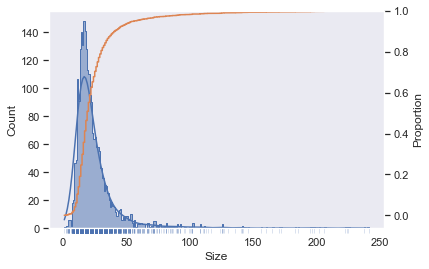

In [88]:
plt.figure()
ax = sns.histplot(data=stats_df, x='Size', kde=True, binwidth=1, element="step")
ax2 = ax.twinx()
g = sns.rugplot(data=stats_df, x="Size", height=-0.02, alpha=.2, clip_on=False)
sns.ecdfplot(data=stats_df, x="Size", stat="proportion")

plt.show()

### Block types

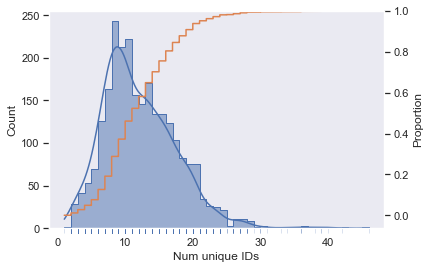

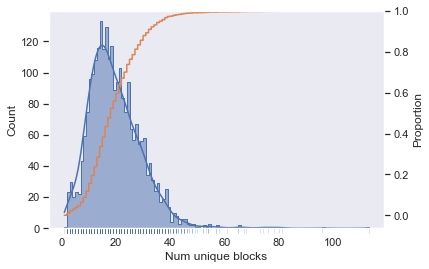

In [89]:
plt.figure()
ax = sns.histplot(data=stats_df, x='Num unique IDs', kde=True, binwidth=1, element="step")
ax2 = ax.twinx()
sns.rugplot(data=stats_df, x="Num unique IDs", height=-0.02, alpha=.2, clip_on=False)
sns.ecdfplot(data=stats_df, x="Num unique IDs", stat="proportion")

plt.show()

plt.figure()
ax = sns.histplot(data=stats_df, x='Num unique blocks', kde=True, binwidth=1, element="step")
ax2 = ax.twinx()
sns.rugplot(data=stats_df, x="Num unique blocks", height=-0.02, alpha=.2, clip_on=False)
sns.ecdfplot(data=stats_df, x="Num unique blocks", stat="proportion")

plt.show()

(0.0, 120.0)

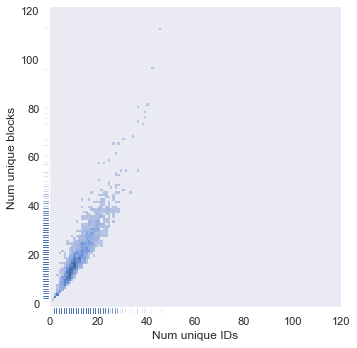

In [90]:
# block types 2d

sns.displot(data=stats_df, x='Num unique IDs', y='Num unique blocks', kind="hist", rug=True, binwidth=1, rug_kws={'height': -0.02, 'alpha': .1, 'clip_on': False})
plt.axis('equal')
plt.ylim(0,120)
plt.xlim(0,120)

### Air blocks

In [91]:
plt.figure()
ax = sns.histplot(data=stats_df, x='Percentage air untrimmed', kde=True, binwidth=0.01, element="step")
ax2 = ax.twinx()
sns.rugplot(data=stats_df, x="Percentage air untrimmed", height=-0.02, alpha=.2, clip_on=False)
sns.ecdfplot(data=stats_df, x="Percentage air untrimmed", stat="proportion")

plt.show()

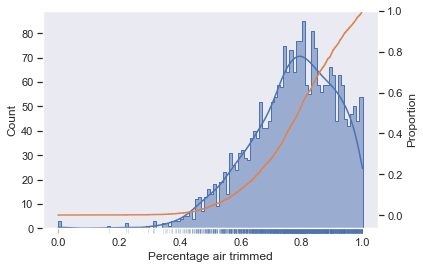

In [92]:
plt.figure()
ax = sns.histplot(data=stats_df, x='Percentage air trimmed', kde=True, binwidth=0.01, element="step")
ax2 = ax.twinx()
sns.rugplot(data=stats_df, x="Percentage air trimmed", height=-0.02, alpha=.2, clip_on=False)
sns.ecdfplot(data=stats_df, x="Percentage air trimmed", stat="proportion")

plt.show()

# Filtering data

The Craft-3D dataset contains several outlying training examples that are too large to be processed in reasonable time. In our experiment, a total of 15 such examples failed to be processed after 10 seconds of timeout and were ignored. 

Prelimilary data exploration suggests that the house size is heavily right-skewed (see fig. _). To select a subset suitable for our model architecture, we removed training example that has any dimension larger than _.

Data exploration also shows that there exist many training examples with an unreasonable proportion of air blocks (see fig. _). To make sure that only reasonable houses are fed to the discriminator, we only include training examples with block mass percentage greater than _%

Seeing that some training examples have very limited variety of block types or overwhelming diverse block types, we select training examples with number of block ids in the range [_, _] and unique block types in the range [, ].

In [14]:
# loop through the stats table
filtered_df = pd.DataFrame()

for i, row in tqdm(stats_df.iterrows(), total=stats_df.shape[0]):
    # unpack
    size, nums_id_types, nums_unique_types, percentages_air, trimmed_percentages_air, dir = row['Size'], row['Num unique IDs'], row['Num unique blocks'], row['Percentage air untrimmed'], row['Percentage air trimmed'], row['dir']
    
    # check size
    size_check = 8 <= size <= 32
    
    # check if reasonable air
    air_check = (1 - trimmed_percentages_air) > 0.05
    
    # check if reasonable block diversity. -1 to account for air block
    diversity_check = (3 <= nums_id_types - 1 <= 30) and (4 <= nums_unique_types - 1 <= 60)
    
    # add to filtered table if conditions met
    if size_check and air_check and diversity_check:
        filtered_df = filtered_df.append({
            'Size': size,
            'Num unique IDs': nums_id_types,
            'Num unique blocks': nums_unique_types,
            'Percentage air untrimmed': percentages_air,
            'Percentage air trimmed': trimmed_percentages_air,
            'dir': row['dir']
        }, ignore_index=True)
    else:
        pass
    
# calculate percentage yield
print('filtering done. collected a total of', len(filtered_df), 'examples', round(len(filtered_df)/len(stats_df)*10000)/100, 'percent of original dataset')

  0%|          | 0/2517 [00:00<?, ?it/s]

filtering done. collected a total of 1977 examples 78.55 percent of original dataset


In [18]:
filtered_df

Size  Num unique IDs  Num unique blocks  Percentage air untrimmed  \
0     23.0             4.0                7.0                  0.955618   
1     15.0            13.0               21.0                  0.789630   
2      9.0             9.0               16.0                  0.786008   
3     32.0            10.0               14.0                  0.979004   
4     12.0            19.0               28.0                  0.692708   
...    ...             ...                ...                       ...   
1972  23.0            23.0               36.0                  0.900140   
1973  11.0             8.0               14.0                  0.758077   
1974  13.0             9.0               16.0                  0.786982   
1975  19.0            23.0               44.0                  0.791223   
1976  23.0            21.0               38.0                  0.944029   

      Percentage air trimmed                                           dir  
0                   0.720497  workdir.2018-08-27-02:34:57.ip-172-31-11-175  
1                   0.561728  workdir.2018-08-26-18:49:04.ip-172-31-10-229  
2                   0.646259  workdir.2018-08-28-02:26:04.ip-172-31-14-122  
3                   0.916016  workdir.2018-08-13-17:17:14.ip-172-31-10-124  
4                   0.664773   workdir.2018-08-04-02:39:29.ip-172-31-8-175  
...                      ...                                           ...  
1972                0.746028   workdir.2018-08-17-00:20:12.ip-172-31-0-206  
1973                0.619835   workdir.2018-08-20-23:12:21.ip-172-31-3-191  
1974                0.727273   workdir.2018-08-05-20:21:21.ip-172-31-2-228  
1975                0.720858   workdir.2018-08-18-18:05:58.ip-172-31-3-100  
1976                0.740275  workdir.2018-08-20-03:29:18.ip-172-31-11-149  

[1977 rows x 6 columns]

The data selection procedure led to a subset of _ valid training examples in the original set of _ houses, which represents _% of the original dataset

In [19]:
# save filtered houses
# filtered_df.to_pickle("filtered_houses_stats.pkl")

In [20]:
# load filtered houses
filtered_df = pd.read_pickle("filtered_houses_stats.pkl")

## Graphing of filtered data

### World sizes

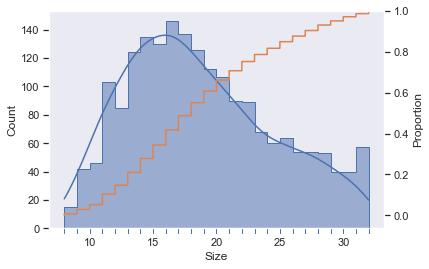

In [95]:
plt.figure()
ax = sns.histplot(data=filtered_df, x='Size', kde=True, binwidth=1, element="step")
ax2 = ax.twinx()
g = sns.rugplot(data=filtered_df, x="Size", height=-0.02, alpha=.2, clip_on=False)
sns.ecdfplot(data=filtered_df, x="Size", stat="proportion")

plt.show()

### Block types

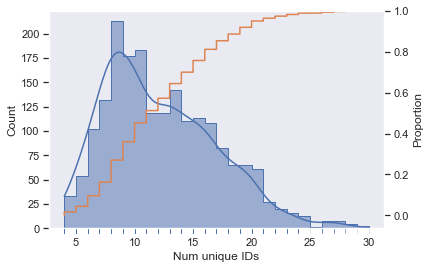

In [96]:
plt.figure()
ax = sns.histplot(data=filtered_df, x='Num unique IDs', kde=True, binwidth=1, element="step")
ax2 = ax.twinx()
sns.rugplot(data=filtered_df, x="Num unique IDs", height=-0.02, alpha=.2, clip_on=False)
sns.ecdfplot(data=filtered_df, x="Num unique IDs", stat="proportion")

plt.show()

plt.figure()
ax = sns.histplot(data=filtered_df, x='Num unique blocks', kde=True, binwidth=1, element="step")
ax2 = ax.twinx()
sns.rugplot(data=filtered_df, x="Num unique blocks", height=-0.02, alpha=.2, clip_on=False)
sns.ecdfplot(data=filtered_df, x="Num unique blocks", stat="proportion")

plt.show()

In [97]:
# block types 2d

sns.displot(data=filtered_df, x='Num unique IDs', y='Num unique blocks', kind="hist", rug=True, binwidth=1, rug_kws={'height': -0.02, 'alpha': .1, 'clip_on': False})
plt.axis('equal')
plt.ylim(0,64)
plt.xlim(0,64)

(0.0, 64.0)

### Air blocks

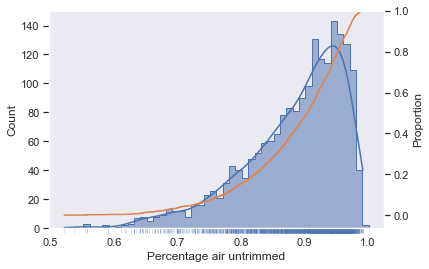

In [98]:
plt.figure()
ax = sns.histplot(data=filtered_df, x='Percentage air untrimmed', kde=True, binwidth=0.01, element="step")
ax2 = ax.twinx()
sns.rugplot(data=filtered_df, x="Percentage air untrimmed", height=-0.02, alpha=.2, clip_on=False)
sns.ecdfplot(data=filtered_df, x="Percentage air untrimmed", stat="proportion")

plt.show()

In [99]:
plt.figure()
ax = sns.histplot(data=filtered_df, x='Percentage air trimmed', kde=True, binwidth=0.01, element="step")
ax2 = ax.twinx()
sns.rugplot(data=filtered_df, x="Percentage air trimmed", height=-0.02, alpha=.2, clip_on=False)
sns.ecdfplot(data=filtered_df, x="Percentage air trimmed", stat="proportion")

plt.show()

## Making Comparison Graphs

In [24]:
concatenated_df = pd.concat([stats_df.assign(dataset='Original'), filtered_df.assign(dataset='Filtered')], ignore_index=True)
concatenated_df

Size  Num unique IDs  Num unique blocks  Percentage air untrimmed  \
0     23.0             4.0                7.0                  0.955618   
1     42.0            13.0               30.0                  0.985180   
2     72.0            20.0               32.0                  0.997471   
3      7.0             9.0               16.0                  0.688047   
4     15.0            13.0               21.0                  0.789630   
...    ...             ...                ...                       ...   
4489  23.0            23.0               36.0                  0.900140   
4490  11.0             8.0               14.0                  0.758077   
4491  13.0             9.0               16.0                  0.786982   
4492  19.0            23.0               44.0                  0.791223   
4493  23.0            21.0               38.0                  0.944029   

      Percentage air trimmed                                           dir  \
0                   0.720497  workdir.2018-08-27-02:34:57.ip-172-31-11-175   
1                   0.935924  workdir.2018-08-25-03:26:13.ip-172-31-13-169   
2                   0.976503    workdir.2018-08-24-21:43:51.ip-172-31-9-19   
3                   0.490476    workdir.2018-08-10-05:48:27.ip-172-31-3-43   
4                   0.561728  workdir.2018-08-26-18:49:04.ip-172-31-10-229   
...                      ...                                           ...   
4489                0.746028   workdir.2018-08-17-00:20:12.ip-172-31-0-206   
4490                0.619835   workdir.2018-08-20-23:12:21.ip-172-31-3-191   
4491                0.727273   workdir.2018-08-05-20:21:21.ip-172-31-2-228   
4492                0.720858   workdir.2018-08-18-18:05:58.ip-172-31-3-100   
4493                0.740275  workdir.2018-08-20-03:29:18.ip-172-31-11-149   

       dataset  
0     Original  
1     Original  
2     Original  
3     Original  
4     Original  
...        ...  
4489  Filtered  
4490  Filtered  
4491  Filtered  
4492  Filtered  
4493  Filtered  

[4494 rows x 7 columns]

### World sizes

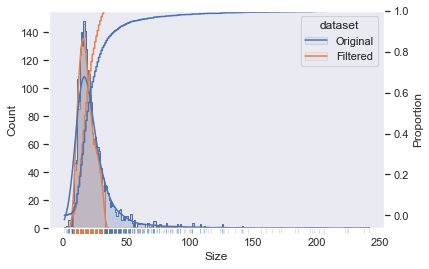

In [30]:
plt.figure()
ax = sns.histplot(data=concatenated_df, x='Size', kde=True, binwidth=1, element="step", hue="dataset")
ax2 = ax.twinx()
g = sns.rugplot(data=concatenated_df, x="Size", height=-0.02, alpha=.2, clip_on=False, hue="dataset")
sns.ecdfplot(data=concatenated_df, x="Size", stat="proportion", hue="dataset")

plt.show()

### Block types

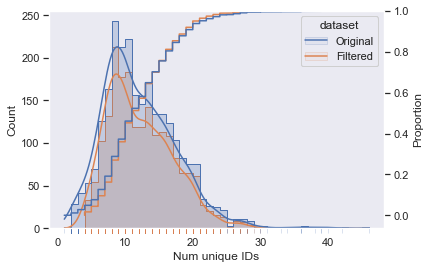

In [31]:
plt.figure()
ax = sns.histplot(data=concatenated_df, x='Num unique IDs', kde=True, binwidth=1, element="step", hue="dataset")
ax2 = ax.twinx()
sns.rugplot(data=concatenated_df, x="Num unique IDs", height=-0.02, alpha=.2, clip_on=False, hue="dataset")
sns.ecdfplot(data=concatenated_df, x="Num unique IDs", stat="proportion", hue="dataset")

plt.show()

plt.figure()
ax = sns.histplot(data=concatenated_df, x='Num unique blocks', kde=True, binwidth=1, element="step", hue="dataset")
ax2 = ax.twinx()
sns.rugplot(data=concatenated_df, x="Num unique blocks", height=-0.02, alpha=.2, clip_on=False, hue="dataset")
sns.ecdfplot(data=concatenated_df, x="Num unique blocks", stat="proportion", hue="dataset")

plt.show()

(0.0, 120.0)

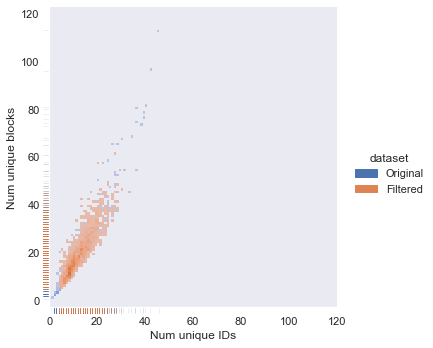

In [39]:
# block types 2d

sns.displot(data=concatenated_df, x='Num unique IDs', y='Num unique blocks', kind="hist", rug=True, binwidth=1, rug_kws={'height': -0.02, 'alpha': .1, 'clip_on': False}, hue="dataset")
plt.axis('equal')
plt.ylim(0,120)
plt.xlim(0,120)

### Air blocks

In [104]:
plt.figure()
ax = sns.histplot(data=concatenated_df, x='Percentage air untrimmed', kde=True, binwidth=0.01, element="step", hue="dataset")
ax2 = ax.twinx()
sns.rugplot(data=concatenated_df, x="Percentage air untrimmed", height=-0.02, alpha=.2, clip_on=False, hue="dataset")
sns.ecdfplot(data=concatenated_df, x="Percentage air untrimmed", stat="proportion", hue="dataset")

plt.show()

In [105]:
plt.figure()
ax = sns.histplot(data=concatenated_df, x='Percentage air trimmed', kde=True, binwidth=0.01, element="step", hue="dataset")
ax2 = ax.twinx()
sns.rugplot(data=concatenated_df, x="Percentage air trimmed", height=-0.02, alpha=.2, clip_on=False, hue="dataset")
sns.ecdfplot(data=concatenated_df, x="Percentage air trimmed", stat="proportion", hue="dataset")

plt.show()

# Cleaning data

Since we apply a fixed size for the world state, we add padding to all the training examples so that the house has dimension 32x32x32

In [22]:
def center_and_pad_world(world):
    world = trim_world_empty(world)
    # this pads a world to the smallest cubic volume that it can fit in
    (x, y, z, m) = world.shape
    min_dim = max(world.shape[0:3])
    x_missing = min_dim - x
    y_missing = min_dim - y
    z_missing = min_dim - z
    
    world = np.pad(world, ((math.floor(x_missing/2), math.ceil(x_missing/2)),(math.floor(y_missing/2), math.ceil(y_missing/2)),(math.floor(z_missing/2), math.ceil(z_missing/2)), (0, 0)), 'constant')
    return world

## Loading and processing training data

Out of the full dataset, 1977 examples are filtered

In [18]:
# load filtered to save time
filtered_df = data_helper.get_filtered_stats_df()

# load all houses

filtered_houses_df = pd.DataFrame()
for i, row in tqdm(filtered_df.iterrows(), total=filtered_df.shape[0]):
    filtered_houses_df = filtered_houses_df.append({
        'world': data_helper.center_and_pad_world(data_helper.trim_world_empty(data_helper.rearrange_sample(np.load(DATA_DIR + "/" + row['dir'] + "/schematic.npy")))),
        'dir': row['dir'],
        'Size': row['Size'],
        'Num unique IDs': row['Num unique IDs'],
        'Num unique blocks': row['Num unique blocks'],
        'Percentage air untrimmed': row['Percentage air untrimmed'],
        'Percentage air trimmed': row['Percentage air trimmed'],
    }, ignore_index=True)

print('loaded', len(filtered_houses_df), 'houses')

  0%|          | 0/1977 [00:00<?, ?it/s]

loaded 1977 houses


colordict init success


  0%|          | 0/100 [00:00<?, ?it/s]

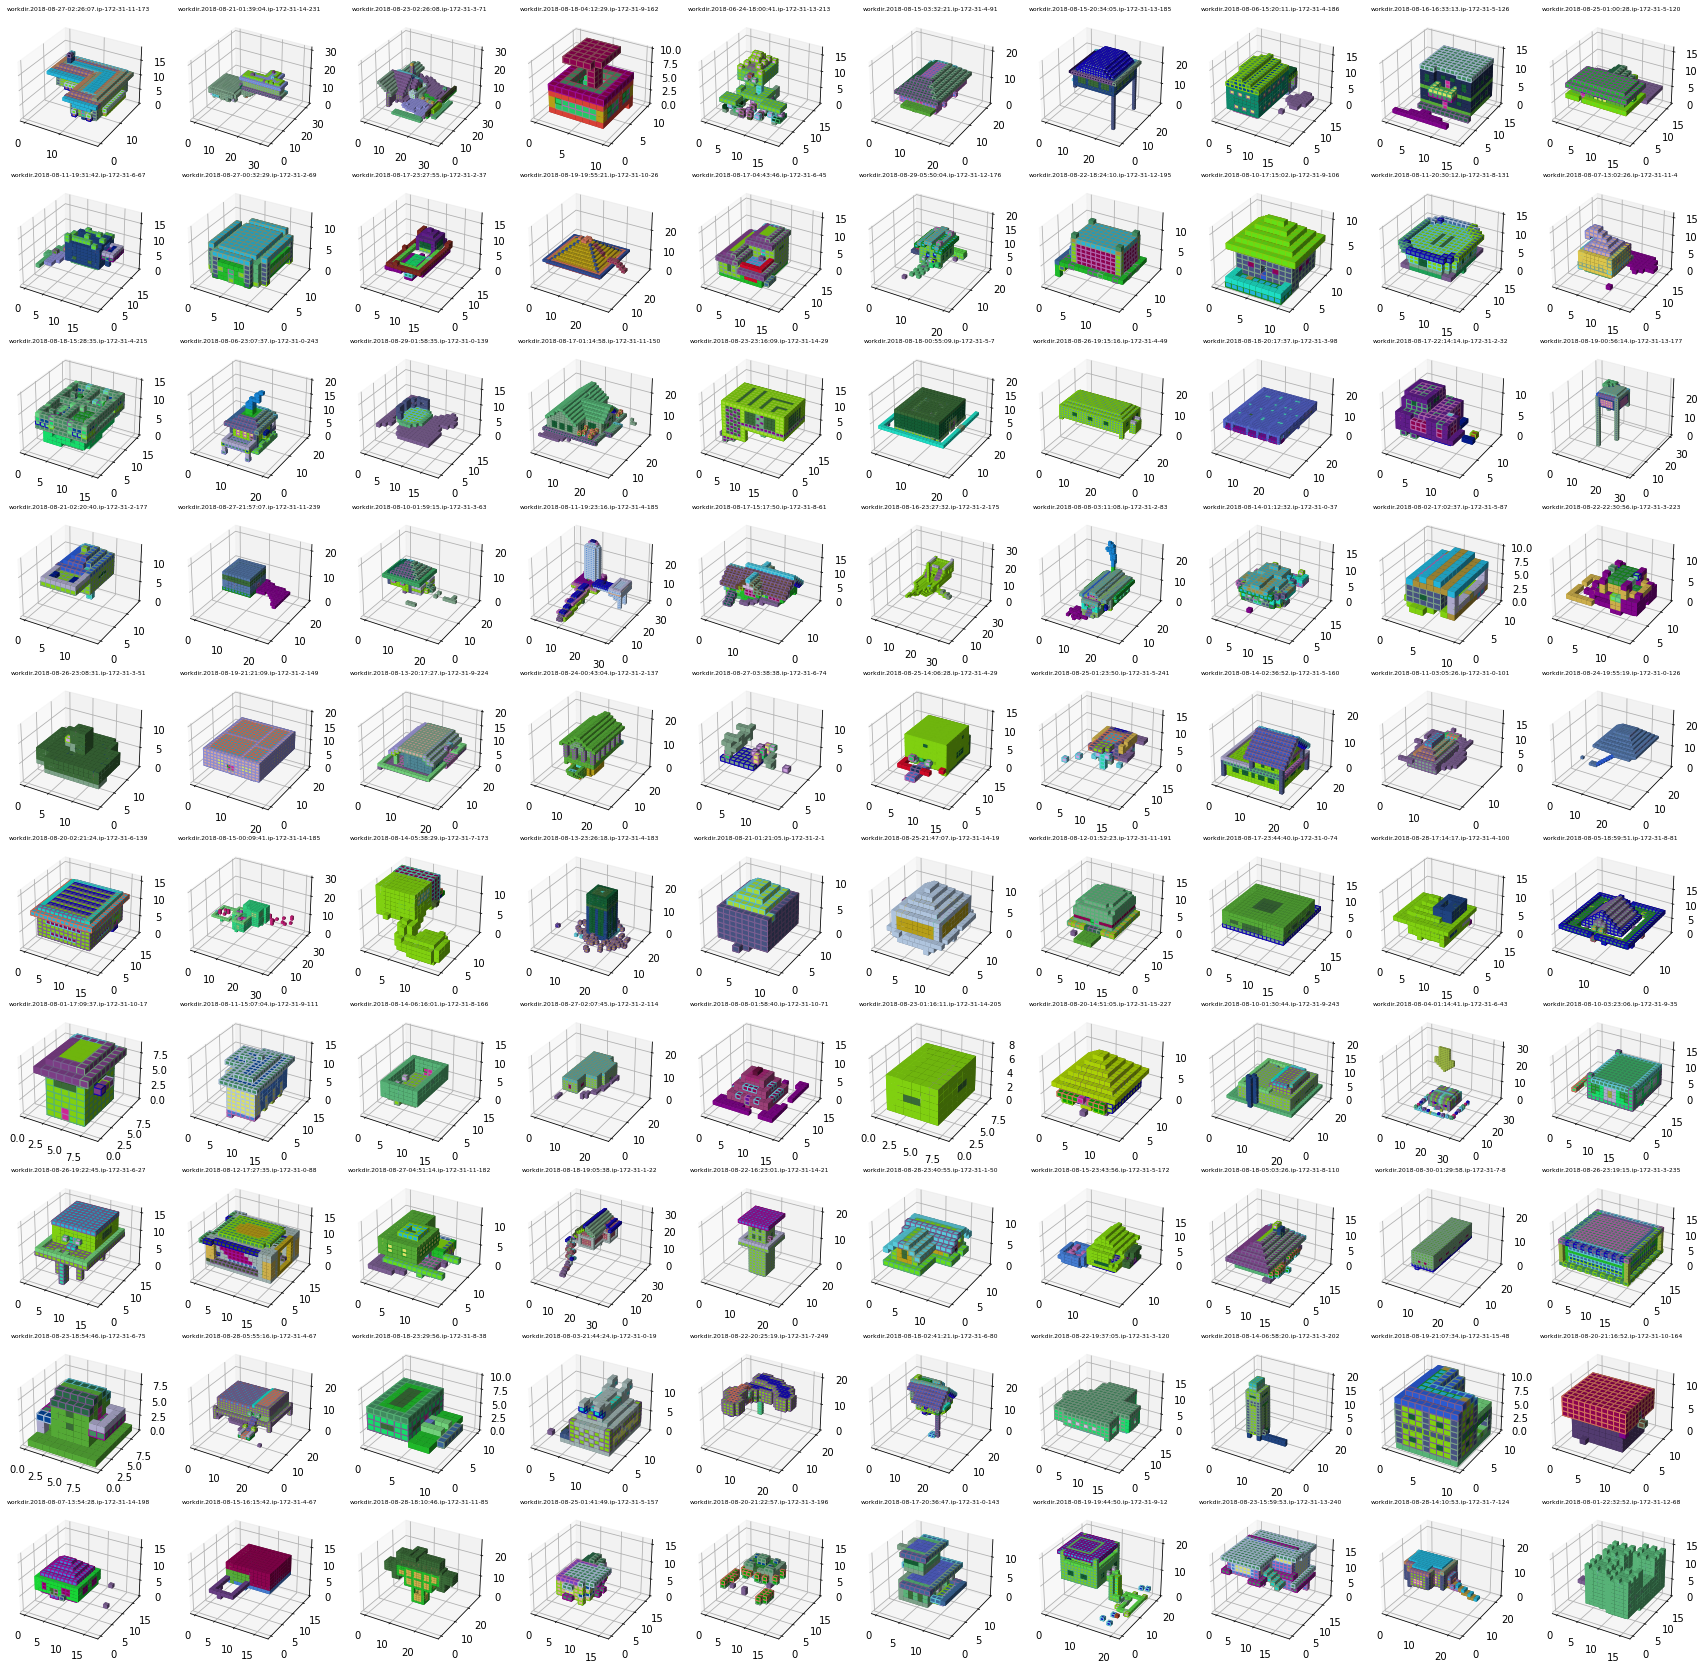

In [19]:
%matplotlib inline

visualise_helper.visualise_world(filtered_houses_df.sample(100), plots_per_row = 10, figsize = (30, 30))